In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import os
pd.options.mode.chained_assignment = None
from typing import List, Tuple

from wlcorr import EncoderDecoderStaticDataset, EncoderDecoder1DCNN
import torch
from torchsummary import summary

In [2]:
class WellCorrelationDataset:
    
    def __init__(self, 
                 root : str = '../data/',
                 train_preload : bool = True,
                 test_preload : bool = False,
                 fill_na_method : str = None):
        self.root : str = root
        self.train_path : str = os.path.join(self.root, 'train.csv')
        self.test_path : str = os.path.join(self.root, 'test.csv')
        self.train_preload : bool = train_preload
        self.test_preload : bool = test_preload
        self.fill_na_method : str = fill_na_method
        self.train_data : pd.DataFrame = None
        self.test_data : pd.DataFrame = None
        self.wells_list = None
        self.target_groups = None
        self.group_num_map = {}
        self.used_cols = ['WELL', 'Z_LOC', 'GR', 'DTC', 'GROUP']

        self.__preload__()
        
    def __preload__(self):
        if self.train_preload:
            self.train_data = pd.read_csv(self.train_path, delimiter=';')
            self.train_data.loc[:, 'Z_LOC'] *= -1
            self.train_data.sort_values(by = ['WELL', 'Z_LOC'])
            self.wells_list = self.train_data.WELL.unique()
            self.target_groups = self.train_data.GROUP.unique()
            for i, label in enumerate(self.target_groups):
                self.group_num_map.update({label : i})
            self.train_data.loc[:, 'GROUP_NUM'] = self.train_data.GROUP.map(self.group_num_map)
            self.used_cols += ['GROUP_NUM']
        
        if self.test_preload:
            self.test_preload = pd.read_csv(self.test_path, delimiter=';')
    
    def get_well(self, idx : str, process_na:bool = True):
        assert(idx in self.wells_list)
        well_df = self.train_data.loc[self.train_data.WELL == idx, self.used_cols]
        if process_na:
            if self.fill_na_method is None:
                well_df.fillna(0., inplace = True)
            else:
                assert(self.fill_na_method in ['ffill', 'bfill', 'pad'])
                well_df.fillna(method = self.fill_na_method, inplace = True)

#             well_df.dropna(inplace = True)
        return well_df
    
    def get_matching_wells_id(self, tmpt : str = ""):
        m_wells = []
        for w in self.wells_list:
            m_wells += [w] if tmpt in w else []
        return m_wells
    
    def show_wells_info(self, idx : str = ""):
        df = self.get_well(idx)
        

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EncoderDecoder1DCNN(2, 50)
model.to(device)
model.load_state_dict(torch.load('./modelstate_vr_loss_l2_dominated'))
model.eval()

EncoderDecoder1DCNN(
  (encoder): Sequential(
    (0): Conv1d(2, 5, kernel_size=(10,), stride=(1,), padding=(9,))
    (1): SELU()
    (2): Conv1d(5, 10, kernel_size=(10,), stride=(1,), padding=(9,))
    (3): SELU()
    (4): Conv1d(10, 10, kernel_size=(10,), stride=(1,), padding=(9,))
    (5): SELU()
    (6): Conv1d(10, 10, kernel_size=(10,), stride=(1,), padding=(9,))
    (7): SELU()
    (8): Conv1d(10, 1, kernel_size=(10,), stride=(1,), padding=(9,))
    (9): SELU()
    (10): Linear(in_features=145, out_features=50, bias=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(1, 5, kernel_size=(10,), stride=(1,))
    (1): SELU()
    (2): ConvTranspose1d(5, 10, kernel_size=(10,), stride=(1,))
    (3): SELU()
    (4): ConvTranspose1d(10, 10, kernel_size=(10,), stride=(1,))
    (5): SELU()
    (6): ConvTranspose1d(10, 5, kernel_size=(10,), stride=(1,))
    (7): SELU()
    (8): ConvTranspose1d(5, 5, kernel_size=(10,), stride=(1,))
    (9): SELU()
    (10): ConvTranspose1d(5, 2, kernel

In [4]:
summary(model.encoder, (2, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 5, 109]             105
              SELU-2               [-1, 5, 109]               0
            Conv1d-3              [-1, 10, 118]             510
              SELU-4              [-1, 10, 118]               0
            Conv1d-5              [-1, 10, 127]           1,010
              SELU-6              [-1, 10, 127]               0
            Conv1d-7              [-1, 10, 136]           1,010
              SELU-8              [-1, 10, 136]               0
            Conv1d-9               [-1, 1, 145]             101
             SELU-10               [-1, 1, 145]               0
           Linear-11                [-1, 1, 50]           7,300
Total params: 10,036
Trainable params: 10,036
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [39]:
def get_window(df : pd.DataFrame, 
               w_size : int = 10, 
               cols : List[str] = ['DTC', 'GR'],
              asymmetric : bool = False) -> Tuple[np.ndarray, List[np.ndarray]]:
    template = []
    group_seq = df.loc[:, 'GROUP_NUM'].values
    diff = np.zeros(group_seq.shape)
    diff[1:] = group_seq[1:] - group_seq[:-1]
    idx = np.where(diff != 0)[0]
    cols = [i if col in cols else None for i, col in enumerate(df.columns) ]
    
    tmp_ = []
    for col in cols:
        if col is not None:
            tmp_ += [col]
            
    cols = tmp_
    
    for i in idx:
        w_list = np.zeros((w_size, len(cols)), dtype = np.float32)
        left_lim, right_lim = max(0, i-w_size//2), min(i+w_size//2, diff.shape[0])
        if asymmetric:
            left_lim, right_lim = max(0, i), min(i+w_size, diff.shape[0])
    
        w_list = df.iloc[left_lim:right_lim, cols].values
        template += [w_list]
    
    return idx, template

In [55]:
def match(target_df, template, cols = [2, 3], asymmetric = False):
    correlation_vals = []
    
    n = target_df.shape[0]
    
    feature_seq = np.float32(target_df.iloc[:, cols].values)
    if asymmetric:
        feature_seq = np.pad(feature_seq, template.shape[1], mode='constant', constant_values = 0)
    else:
        feature_seq = np.pad(feature_seq, template.shape[1]//2, mode='constant', constant_values = 0)

    template_emb = model.encoder(template).flatten()
    template_emb = template_emb.detach().cpu().numpy()
    template_emb /= np.linalg.norm(template_emb)
    
    left_offset, right_offset = template.shape[-1]//2, template.shape[-1]//2
    if asymmetric:
        left_offset, right_offset = 0, template.shape[-1]
    
    for k in range(left_offset, n-right_offset):
        local_patch = np.float32(feature_seq[k-left_offset:k+right_offset, cols]).T
        local_patch /= np.linalg.norm(local_patch, axis=1, keepdims=True)+0.000001
        local_patch /= np.linalg.norm(local_patch, axis=0, keepdims=True)+0.000001
        local_patch = torch.from_numpy(local_patch).unsqueeze(dim=0)
        local_patch = local_patch.to(device)
        if (local_patch.shape != template.shape):
            print(f'Found local patch mismatch {k}, {local_patch.shape}, {k-template.shape[-1]//2, k + template.shape[-1]//2}')
            continue
        local_patch_embed = model.encoder(local_patch).flatten()
        local_patch_embed = local_patch_embed.detach().cpu().numpy()
        local_patch_embed /= np.linalg.norm(local_patch_embed)
        
        correlation_vals += [template_emb.dot(local_patch_embed)]
    
    return np.array(correlation_vals, dtype=np.float32)

In [56]:
dataset = WellCorrelationDataset(fill_na_method=None)

In [64]:
dataset.wells_list

array(['15/9-13', '15/9-15', '15/9-17', '16/1-2', '16/1-6 A', '16/10-1',
       '16/10-2', '16/10-3', '16/10-5', '16/11-1 ST3', '16/2-11 A',
       '16/2-16', '16/2-6', '16/4-1', '16/5-3', '16/7-4', '16/7-5',
       '16/8-1', '17/11-1', '25/11-15', '25/11-19 S', '25/11-5',
       '25/2-13 T4', '25/2-14', '25/2-7', '25/3-1', '25/4-5', '25/5-1',
       '25/5-4', '25/6-1', '25/6-2', '25/6-3', '25/7-2', '25/8-5 S',
       '25/8-7', '25/9-1', '26/4-1', '29/6-1', '30/3-3', '30/3-5 S',
       '30/6-5', '31/2-1', '31/2-19 S', '31/2-7', '31/2-8', '31/2-9',
       '31/3-1', '31/3-2', '31/3-3', '31/3-4', '31/4-10', '31/4-5',
       '31/5-4 S', '31/6-5', '31/6-8', '32/2-1', '33/5-2', '33/6-3 S',
       '33/9-1', '33/9-17', '34/10-19', '34/10-21', '34/10-33',
       '34/10-35', '34/11-1', '34/11-2 S', '34/12-1', '34/2-4',
       '34/3-1 A', '34/4-10 R', '34/5-1 A', '34/5-1 S', '34/7-13',
       '34/7-20', '34/7-21', '34/8-1', '34/8-3', '34/8-7 R', '35/11-1',
       '35/11-10', '35/11-11', '35/11-12

In [57]:
matching_wells = dataset.get_matching_wells_id("31/2")
print(f'matching wells ids : {matching_wells}')

matching wells ids : ['31/2-1', '31/2-19 S', '31/2-7', '31/2-8', '31/2-9']


In [77]:
def get_matching_results(matching_wells, asymmetric=False):
    df_w1_reference = dataset.get_well(matching_wells[0])
    idx, templates = get_window(df_w1_reference, 100, asymmetric=asymmetric)
    
    for idx_, group_num, template in zip(idx, df_w1_reference.iloc[idx].GROUP_NUM.values, templates):
        # Define target template
        target_template = np.float32(template).T
        target_template /= np.linalg.norm(target_template, axis=1, keepdims=True)+0.000001
        target_template /= np.linalg.norm(target_template, axis=0, keepdims=True)+0.000001
        target_template = torch.from_numpy(target_template).unsqueeze(dim=0)
        target_template = target_template.to(device)

        for well in matching_wells[1:]:
            source_df = dataset.get_well(well)

            correlation_vals = match(source_df, target_template, asymmetric=asymmetric)

            print(f'correlation shape : {correlation_vals.shape}')
            matching_idx = np.argsort(correlation_vals)[-len(correlation_vals)//20:]
            matching_z_vals = source_df.Z_LOC.values[matching_idx]
            correlation_vals_match = correlation_vals[matching_idx]

            source_idx, _ = get_window(source_df, 100, asymmetric=asymmetric)
            group_nums = np.float32(source_df.iloc[source_idx].GROUP_NUM.values)
            gt_id = source_idx[group_nums == group_num]
            gt_matching_loc = source_df.Z_LOC.values[gt_id]

            matching_z_val = 'Not applicable'

            if len(gt_matching_loc) == 0:
                gt_matching_loc = 'Not found'
            else:
                gt_matching_loc = gt_matching_loc[0]
                matching_z_val = matching_z_vals[np.argmin(np.abs(matching_z_vals - gt_matching_loc))]
                plt.plot(correlation_vals[max(gt_id[0]-1000, 0):min(gt_id[0]+1000, len(correlation_vals))])
                plt.show()

            print(f'Target well : 31/2-1, {group_num}, \nSource well : {well, source_idx, group_nums}, \nmatching target loc: {matching_z_val} vs {gt_matching_loc}')
            print('\n------------------------------------------------------')
            print('------------------------------------------------------\n')

matching wells ids : ['31/2-1', '31/2-19 S', '31/2-7', '31/2-8', '31/2-9']
correlation shape : (16355,)


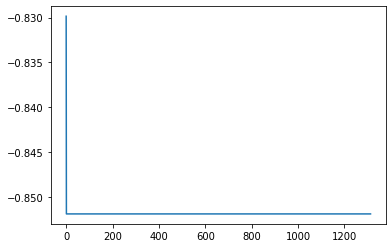

Target well : 31/2-1, 2, 
Source well : ('31/2-19 S', array([  314,  3874,  6314,  6841, 12453, 13532]), array([ 2.,  3.,  4.,  5., 13., 12.], dtype=float32)), 
matching target loc: 1559.671753 vs 1560.697998

------------------------------------------------------
------------------------------------------------------

correlation shape : (7904,)


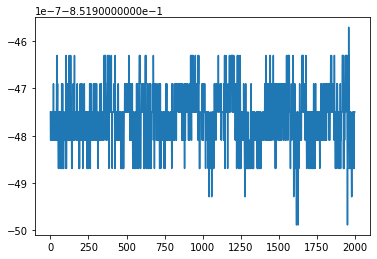

Target well : 31/2-1, 2, 
Source well : ('31/2-7', array([2213, 5687, 7180, 7207]), array([1., 2., 4., 5.], dtype=float32)), 
matching target loc: 1610.057983 vs 1279.025757

------------------------------------------------------
------------------------------------------------------

correlation shape : (18925,)


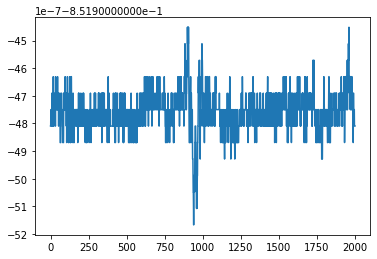

Target well : 31/2-1, 2, 
Source well : ('31/2-8', array([ 1918,  6233,  8733,  8819, 13391, 14713, 18328]), array([ 1.,  2.,  3.,  5., 13., 12.,  8.], dtype=float32)), 
matching target loc: 1402.498535 vs 1402.95459

------------------------------------------------------
------------------------------------------------------

correlation shape : (8599,)


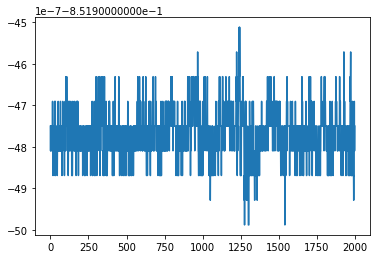

Target well : 31/2-1, 2, 
Source well : ('31/2-9', array([2127, 5581, 7213, 7239]), array([1., 2., 4., 5.], dtype=float32)), 
matching target loc: 1261.958862 vs 1266.974243

------------------------------------------------------
------------------------------------------------------

correlation shape : (16355,)


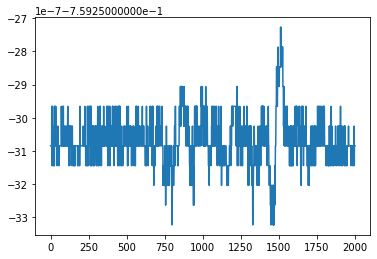

Target well : 31/2-1, 4, 
Source well : ('31/2-19 S', array([  314,  3874,  6314,  6841, 12453, 13532]), array([ 2.,  3.,  4.,  5., 13., 12.], dtype=float32)), 
matching target loc: 2297.78833 vs 2298.14502

------------------------------------------------------
------------------------------------------------------

correlation shape : (7904,)


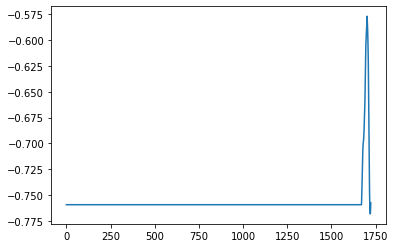

Target well : 31/2-1, 4, 
Source well : ('31/2-7', array([2213, 5687, 7180, 7207]), array([1., 2., 4., 5.], dtype=float32)), 
matching target loc: 1611.729858 vs 1505.940918

------------------------------------------------------
------------------------------------------------------

correlation shape : (18925,)
Target well : 31/2-1, 4, 
Source well : ('31/2-8', array([ 1918,  6233,  8733,  8819, 13391, 14713, 18328]), array([ 1.,  2.,  3.,  5., 13., 12.,  8.], dtype=float32)), 
matching target loc: Not applicable vs Not found

------------------------------------------------------
------------------------------------------------------

correlation shape : (8599,)


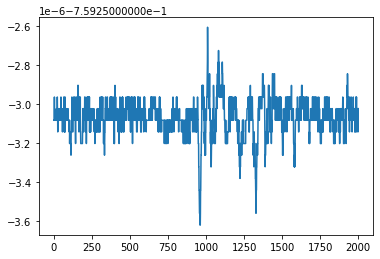

Target well : 31/2-1, 4, 
Source well : ('31/2-9', array([2127, 5581, 7213, 7239]), array([1., 2., 4., 5.], dtype=float32)), 
matching target loc: 1516.017334 vs 1514.953857

------------------------------------------------------
------------------------------------------------------

correlation shape : (16355,)


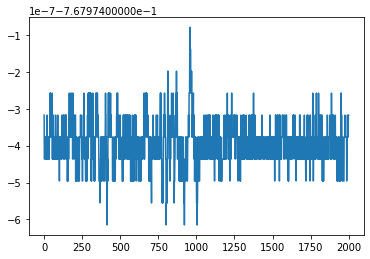

Target well : 31/2-1, 5, 
Source well : ('31/2-19 S', array([  314,  3874,  6314,  6841, 12453, 13532]), array([ 2.,  3.,  4.,  5., 13., 12.], dtype=float32)), 
matching target loc: 2358.592529 vs 2360.988281

------------------------------------------------------
------------------------------------------------------

correlation shape : (7904,)


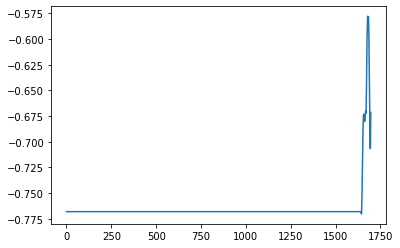

Target well : 31/2-1, 5, 
Source well : ('31/2-7', array([2213, 5687, 7180, 7207]), array([1., 2., 4., 5.], dtype=float32)), 
matching target loc: 1611.425781 vs 1510.0448

------------------------------------------------------
------------------------------------------------------

correlation shape : (18925,)


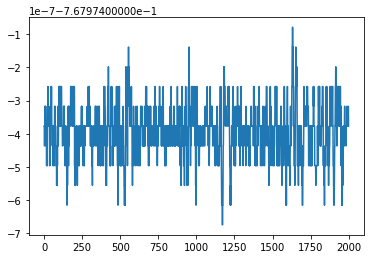

Target well : 31/2-1, 5, 
Source well : ('31/2-8', array([ 1918,  6233,  8733,  8819, 13391, 14713, 18328]), array([ 1.,  2.,  3.,  5., 13., 12.,  8.], dtype=float32)), 
matching target loc: 1796.593994 vs 1795.986206

------------------------------------------------------
------------------------------------------------------

correlation shape : (8599,)


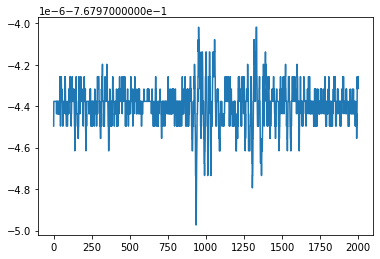

Target well : 31/2-1, 5, 
Source well : ('31/2-9', array([2127, 5581, 7213, 7239]), array([1., 2., 4., 5.], dtype=float32)), 
matching target loc: 1518.903564 vs 1518.903564

------------------------------------------------------
------------------------------------------------------

correlation shape : (16355,)


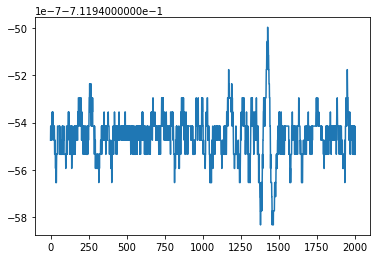

Target well : 31/2-1, 13, 
Source well : ('31/2-19 S', array([  314,  3874,  6314,  6841, 12453, 13532]), array([ 2.,  3.,  4.,  5., 13., 12.], dtype=float32)), 
matching target loc: 3070.519775 vs 3070.638916

------------------------------------------------------
------------------------------------------------------

correlation shape : (7904,)
Target well : 31/2-1, 13, 
Source well : ('31/2-7', array([2213, 5687, 7180, 7207]), array([1., 2., 4., 5.], dtype=float32)), 
matching target loc: Not applicable vs Not found

------------------------------------------------------
------------------------------------------------------

correlation shape : (18925,)


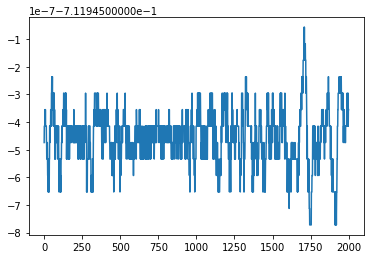

Target well : 31/2-1, 13, 
Source well : ('31/2-8', array([ 1918,  6233,  8733,  8819, 13391, 14713, 18328]), array([ 1.,  2.,  3.,  5., 13., 12.,  8.], dtype=float32)), 
matching target loc: 2537.123291 vs 2491.877441

------------------------------------------------------
------------------------------------------------------

correlation shape : (8599,)
Target well : 31/2-1, 13, 
Source well : ('31/2-9', array([2127, 5581, 7213, 7239]), array([1., 2., 4., 5.], dtype=float32)), 
matching target loc: Not applicable vs Not found

------------------------------------------------------
------------------------------------------------------

correlation shape : (16355,)


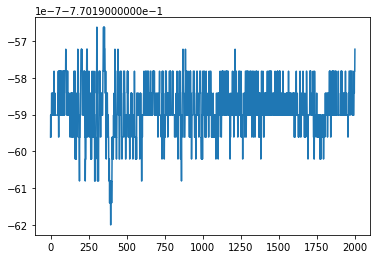

Target well : 31/2-1, 12, 
Source well : ('31/2-19 S', array([  314,  3874,  6314,  6841, 12453, 13532]), array([ 2.,  3.,  4.,  5., 13., 12.], dtype=float32)), 
matching target loc: 3201.791504 vs 3201.791504

------------------------------------------------------
------------------------------------------------------

correlation shape : (7904,)
Target well : 31/2-1, 12, 
Source well : ('31/2-7', array([2213, 5687, 7180, 7207]), array([1., 2., 4., 5.], dtype=float32)), 
matching target loc: Not applicable vs Not found

------------------------------------------------------
------------------------------------------------------

correlation shape : (18925,)


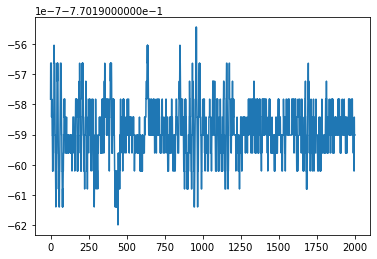

Target well : 31/2-1, 12, 
Source well : ('31/2-8', array([ 1918,  6233,  8733,  8819, 13391, 14713, 18328]), array([ 1.,  2.,  3.,  5., 13., 12.,  8.], dtype=float32)), 
matching target loc: 2691.661377 vs 2695.15332

------------------------------------------------------
------------------------------------------------------

correlation shape : (8599,)
Target well : 31/2-1, 12, 
Source well : ('31/2-9', array([2127, 5581, 7213, 7239]), array([1., 2., 4., 5.], dtype=float32)), 
matching target loc: Not applicable vs Not found

------------------------------------------------------
------------------------------------------------------

correlation shape : (16355,)
Target well : 31/2-1, 8, 
Source well : ('31/2-19 S', array([  314,  3874,  6314,  6841, 12453, 13532]), array([ 2.,  3.,  4.,  5., 13., 12.], dtype=float32)), 
matching target loc: Not applicable vs Not found

------------------------------------------------------
------------------------------------------------------

cor

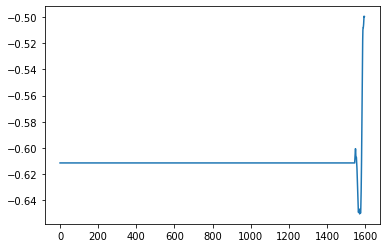

Target well : 31/2-1, 8, 
Source well : ('31/2-8', array([ 1918,  6233,  8733,  8819, 13391, 14713, 18328]), array([ 1.,  2.,  3.,  5., 13., 12.,  8.], dtype=float32)), 
matching target loc: 3247.153564 vs 3247.153564

------------------------------------------------------
------------------------------------------------------

correlation shape : (8599,)
Target well : 31/2-1, 8, 
Source well : ('31/2-9', array([2127, 5581, 7213, 7239]), array([1., 2., 4., 5.], dtype=float32)), 
matching target loc: Not applicable vs Not found

------------------------------------------------------
------------------------------------------------------



In [78]:
matching_wells = dataset.get_matching_wells_id("31/2")
print(f'matching wells ids : {matching_wells}')
get_matching_results(matching_wells)

matching wells ids : ['15/9-13', '15/9-15', '15/9-17']
correlation shape : (17617,)


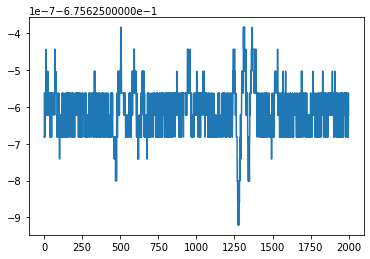

Target well : 31/2-1, 1, 
Source well : ('15/9-15', array([ 4236, 11334, 12645, 14575, 14784, 15244]), array([1., 2., 3., 4., 5., 8.], dtype=float32)), 
matching target loc: 1151.062012 vs 1104.096313

------------------------------------------------------
------------------------------------------------------

correlation shape : (17250,)


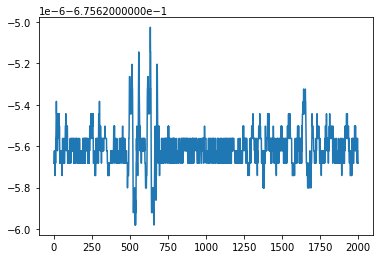

Target well : 31/2-1, 1, 
Source well : ('15/9-17', array([ 4853, 11386, 13248, 14682, 14735, 14754]), array([1., 2., 3., 4., 5., 6.], dtype=float32)), 
matching target loc: 1234.865967 vs 1188.05188

------------------------------------------------------
------------------------------------------------------

correlation shape : (17617,)


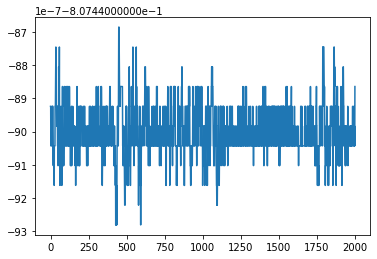

Target well : 31/2-1, 2, 
Source well : ('15/9-15', array([ 4236, 11334, 12645, 14575, 14784, 15244]), array([1., 2., 3., 4., 5., 8.], dtype=float32)), 
matching target loc: 2181.685059 vs 2182.748779

------------------------------------------------------
------------------------------------------------------

correlation shape : (17250,)


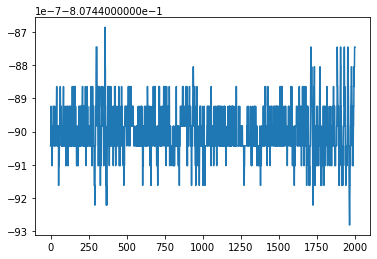

Target well : 31/2-1, 2, 
Source well : ('15/9-17', array([ 4853, 11386, 13248, 14682, 14735, 14754]), array([1., 2., 3., 4., 5., 6.], dtype=float32)), 
matching target loc: 2175.193359 vs 2180.96875

------------------------------------------------------
------------------------------------------------------

correlation shape : (17617,)


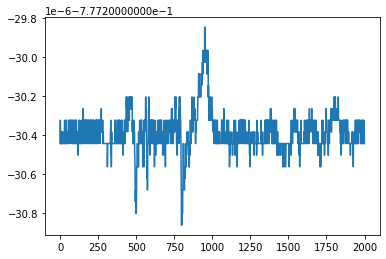

Target well : 31/2-1, 3, 
Source well : ('15/9-15', array([ 4236, 11334, 12645, 14575, 14784, 15244]), array([1., 2., 3., 4., 5., 8.], dtype=float32)), 
matching target loc: 2392.630615 vs 2392.782471

------------------------------------------------------
------------------------------------------------------

correlation shape : (17250,)


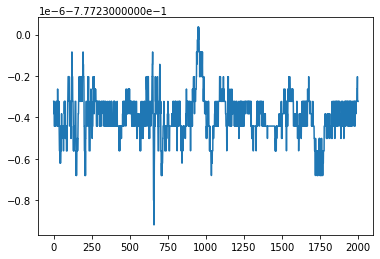

Target well : 31/2-1, 3, 
Source well : ('15/9-17', array([ 4853, 11386, 13248, 14682, 14735, 14754]), array([1., 2., 3., 4., 5., 6.], dtype=float32)), 
matching target loc: 2463.64209 vs 2463.946045

------------------------------------------------------
------------------------------------------------------

correlation shape : (17617,)


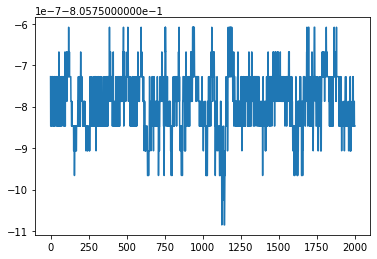

Target well : 31/2-1, 4, 
Source well : ('15/9-15', array([ 4236, 11334, 12645, 14575, 14784, 15244]), array([1., 2., 3., 4., 5., 8.], dtype=float32)), 
matching target loc: 2685.181641 vs 2693.69043

------------------------------------------------------
------------------------------------------------------

correlation shape : (17250,)


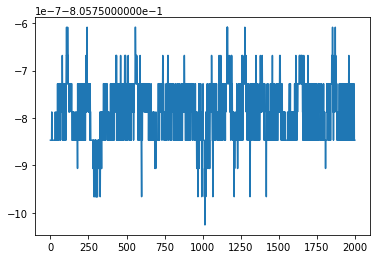

Target well : 31/2-1, 4, 
Source well : ('15/9-17', array([ 4853, 11386, 13248, 14682, 14735, 14754]), array([1., 2., 3., 4., 5., 6.], dtype=float32)), 
matching target loc: 2690.707275 vs 2681.892334

------------------------------------------------------
------------------------------------------------------

correlation shape : (17617,)


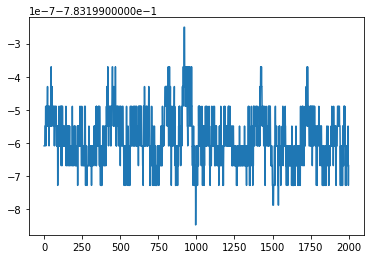

Target well : 31/2-1, 5, 
Source well : ('15/9-15', array([ 4236, 11334, 12645, 14575, 14784, 15244]), array([1., 2., 3., 4., 5., 8.], dtype=float32)), 
matching target loc: 2720.88916 vs 2725.751465

------------------------------------------------------
------------------------------------------------------

correlation shape : (17250,)


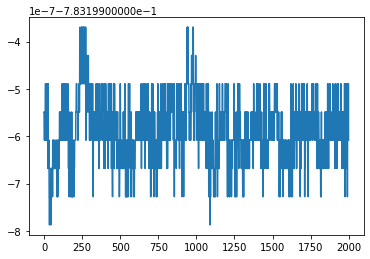

Target well : 31/2-1, 5, 
Source well : ('15/9-17', array([ 4853, 11386, 13248, 14682, 14735, 14754]), array([1., 2., 3., 4., 5., 6.], dtype=float32)), 
matching target loc: 2689.1875 vs 2689.94751

------------------------------------------------------
------------------------------------------------------

correlation shape : (17617,)
Target well : 31/2-1, 6, 
Source well : ('15/9-15', array([ 4236, 11334, 12645, 14575, 14784, 15244]), array([1., 2., 3., 4., 5., 8.], dtype=float32)), 
matching target loc: Not applicable vs Not found

------------------------------------------------------
------------------------------------------------------

correlation shape : (17250,)


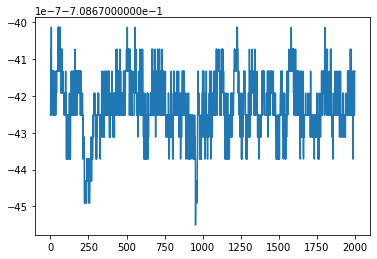

Target well : 31/2-1, 6, 
Source well : ('15/9-17', array([ 4853, 11386, 13248, 14682, 14735, 14754]), array([1., 2., 3., 4., 5., 6.], dtype=float32)), 
matching target loc: 2706.363037 vs 2692.835449

------------------------------------------------------
------------------------------------------------------

correlation shape : (17617,)
Target well : 31/2-1, 7, 
Source well : ('15/9-15', array([ 4236, 11334, 12645, 14575, 14784, 15244]), array([1., 2., 3., 4., 5., 8.], dtype=float32)), 
matching target loc: Not applicable vs Not found

------------------------------------------------------
------------------------------------------------------

correlation shape : (17250,)
Target well : 31/2-1, 7, 
Source well : ('15/9-17', array([ 4853, 11386, 13248, 14682, 14735, 14754]), array([1., 2., 3., 4., 5., 6.], dtype=float32)), 
matching target loc: Not applicable vs Not found

------------------------------------------------------
------------------------------------------------------



In [79]:
matching_wells = dataset.get_matching_wells_id("15/9")
print(f'matching wells ids : {matching_wells}')
get_matching_results(matching_wells)

matching wells ids : ['16/10-1', '16/10-2', '16/10-3', '16/10-5']
correlation shape : (2337,)
Target well : 31/2-1, 1, 
Source well : ('16/10-2', array([ 71, 334, 565]), array([4., 5., 6.], dtype=float32)), 
matching target loc: Not applicable vs Not found

------------------------------------------------------
------------------------------------------------------

correlation shape : (15856,)


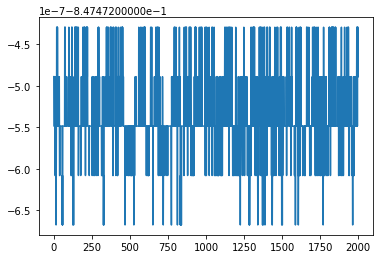

Target well : 31/2-1, 1, 
Source well : ('16/10-3', array([ 3966,  9301, 10617, 12801, 13722, 13854]), array([1., 2., 3., 4., 5., 6.], dtype=float32)), 
matching target loc: 972.7422485 vs 978.0622559

------------------------------------------------------
------------------------------------------------------

correlation shape : (2665,)
Target well : 31/2-1, 1, 
Source well : ('16/10-5', array([ 672, 1474, 2119]), array([ 4., 10.,  6.], dtype=float32)), 
matching target loc: Not applicable vs Not found

------------------------------------------------------
------------------------------------------------------

correlation shape : (2337,)
Target well : 31/2-1, 2, 
Source well : ('16/10-2', array([ 71, 334, 565]), array([4., 5., 6.], dtype=float32)), 
matching target loc: Not applicable vs Not found

------------------------------------------------------
------------------------------------------------------

correlation shape : (15856,)


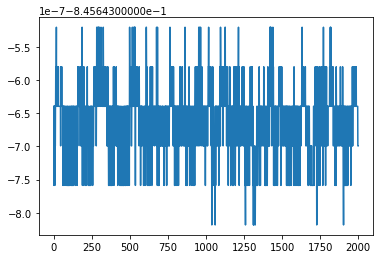

Target well : 31/2-1, 2, 
Source well : ('16/10-3', array([ 3966,  9301, 10617, 12801, 13722, 13854]), array([1., 2., 3., 4., 5., 6.], dtype=float32)), 
matching target loc: 1791.041992 vs 1788.914551

------------------------------------------------------
------------------------------------------------------

correlation shape : (2665,)
Target well : 31/2-1, 2, 
Source well : ('16/10-5', array([ 672, 1474, 2119]), array([ 4., 10.,  6.], dtype=float32)), 
matching target loc: Not applicable vs Not found

------------------------------------------------------
------------------------------------------------------

correlation shape : (2337,)
Target well : 31/2-1, 3, 
Source well : ('16/10-2', array([ 71, 334, 565]), array([4., 5., 6.], dtype=float32)), 
matching target loc: Not applicable vs Not found

------------------------------------------------------
------------------------------------------------------

correlation shape : (15856,)


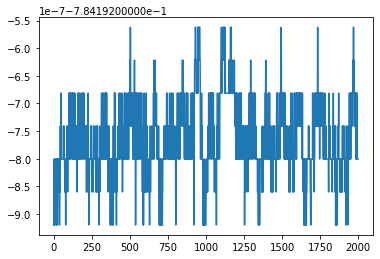

Target well : 31/2-1, 3, 
Source well : ('16/10-3', array([ 3966,  9301, 10617, 12801, 13722, 13854]), array([1., 2., 3., 4., 5., 6.], dtype=float32)), 
matching target loc: 1991.405029 vs 1988.823975

------------------------------------------------------
------------------------------------------------------

correlation shape : (2665,)
Target well : 31/2-1, 3, 
Source well : ('16/10-5', array([ 672, 1474, 2119]), array([ 4., 10.,  6.], dtype=float32)), 
matching target loc: Not applicable vs Not found

------------------------------------------------------
------------------------------------------------------

correlation shape : (2337,)


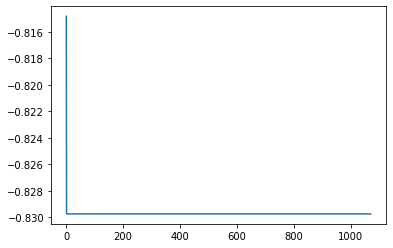

Target well : 31/2-1, 4, 
Source well : ('16/10-2', array([ 71, 334, 565]), array([4., 5., 6.], dtype=float32)), 
matching target loc: 2748.705078 vs 2750.83252

------------------------------------------------------
------------------------------------------------------

correlation shape : (15856,)


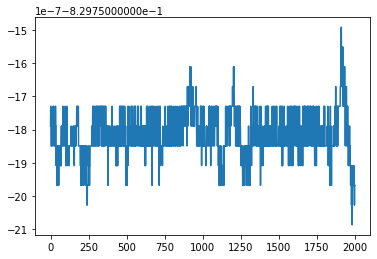

Target well : 31/2-1, 4, 
Source well : ('16/10-3', array([ 3966,  9301, 10617, 12801, 13722, 13854]), array([1., 2., 3., 4., 5., 6.], dtype=float32)), 
matching target loc: 2320.217773 vs 2320.673584

------------------------------------------------------
------------------------------------------------------

correlation shape : (2665,)


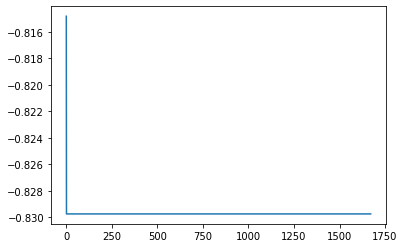

Target well : 31/2-1, 4, 
Source well : ('16/10-5', array([ 672, 1474, 2119]), array([ 4., 10.,  6.], dtype=float32)), 
matching target loc: 2704.694092 vs 2665.637695

------------------------------------------------------
------------------------------------------------------

correlation shape : (2337,)


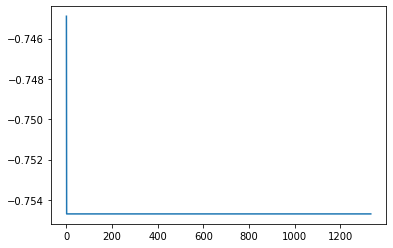

Target well : 31/2-1, 5, 
Source well : ('16/10-2', array([ 71, 334, 565]), array([4., 5., 6.], dtype=float32)), 
matching target loc: 2788.970459 vs 2790.793701

------------------------------------------------------
------------------------------------------------------

correlation shape : (15856,)


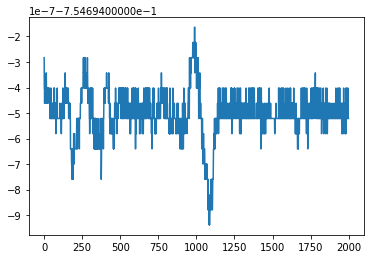

Target well : 31/2-1, 5, 
Source well : ('16/10-3', array([ 3966,  9301, 10617, 12801, 13722, 13854]), array([1., 2., 3., 4., 5., 6.], dtype=float32)), 
matching target loc: 2460.609375 vs 2460.609375

------------------------------------------------------
------------------------------------------------------

correlation shape : (2665,)
Target well : 31/2-1, 5, 
Source well : ('16/10-5', array([ 672, 1474, 2119]), array([ 4., 10.,  6.], dtype=float32)), 
matching target loc: Not applicable vs Not found

------------------------------------------------------
------------------------------------------------------

correlation shape : (2337,)


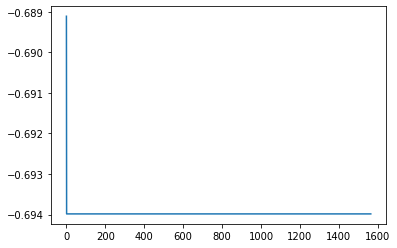

Target well : 31/2-1, 6, 
Source well : ('16/10-2', array([ 71, 334, 565]), array([4., 5., 6.], dtype=float32)), 
matching target loc: 2822.09375 vs 2825.892578

------------------------------------------------------
------------------------------------------------------

correlation shape : (15856,)


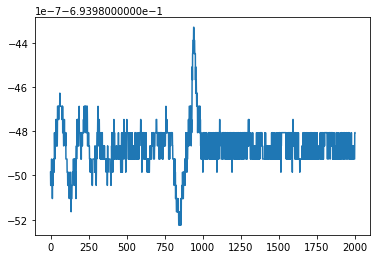

Target well : 31/2-1, 6, 
Source well : ('16/10-3', array([ 3966,  9301, 10617, 12801, 13722, 13854]), array([1., 2., 3., 4., 5., 6.], dtype=float32)), 
matching target loc: 2478.232666 vs 2480.66333

------------------------------------------------------
------------------------------------------------------

correlation shape : (2665,)


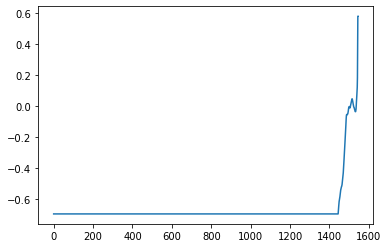

Target well : 31/2-1, 6, 
Source well : ('16/10-5', array([ 672, 1474, 2119]), array([ 4., 10.,  6.], dtype=float32)), 
matching target loc: 2880.165527 vs 2885.481689

------------------------------------------------------
------------------------------------------------------

correlation shape : (2337,)
Target well : 31/2-1, 7, 
Source well : ('16/10-2', array([ 71, 334, 565]), array([4., 5., 6.], dtype=float32)), 
matching target loc: Not applicable vs Not found

------------------------------------------------------
------------------------------------------------------

correlation shape : (15856,)
Target well : 31/2-1, 7, 
Source well : ('16/10-3', array([ 3966,  9301, 10617, 12801, 13722, 13854]), array([1., 2., 3., 4., 5., 6.], dtype=float32)), 
matching target loc: Not applicable vs Not found

------------------------------------------------------
------------------------------------------------------

correlation shape : (2665,)
Target well : 31/2-1, 7, 
Source well : ('16/1

In [80]:
matching_wells = dataset.get_matching_wells_id("16/10")
print(f'matching wells ids : {matching_wells}')
get_matching_results(matching_wells)

matching wells ids : ['16/2-11 A', '16/2-16', '16/2-6']
correlation shape : (9925,)


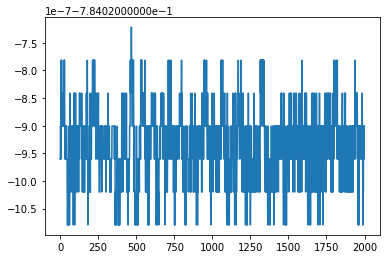

Target well : 31/2-1, 1, 
Source well : ('16/2-16', array([2025, 5400, 6584, 7499, 8301, 8420, 8650, 9084, 9742]), array([1., 2., 3., 4., 5., 6., 8., 7., 9.], dtype=float32)), 
matching target loc: 959.9296875 vs 965.7056885

------------------------------------------------------
------------------------------------------------------

correlation shape : (9038,)


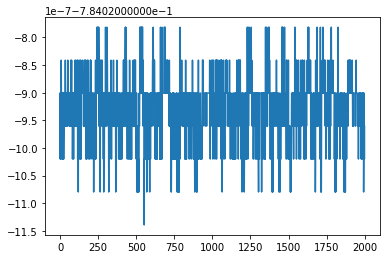

Target well : 31/2-1, 1, 
Source well : ('16/2-6', array([1341, 4822, 5874, 7039, 7835, 7940, 8815]), array([1., 2., 3., 4., 5., 6., 7.], dtype=float32)), 
matching target loc: 717.6565552 vs 912.9684448

------------------------------------------------------
------------------------------------------------------

correlation shape : (9925,)


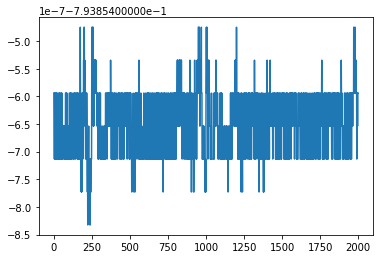

Target well : 31/2-1, 2, 
Source well : ('16/2-16', array([2025, 5400, 6584, 7499, 8301, 8420, 8650, 9084, 9742]), array([1., 2., 3., 4., 5., 6., 8., 7., 9.], dtype=float32)), 
matching target loc: 1479.009399 vs 1478.705444

------------------------------------------------------
------------------------------------------------------

correlation shape : (9038,)


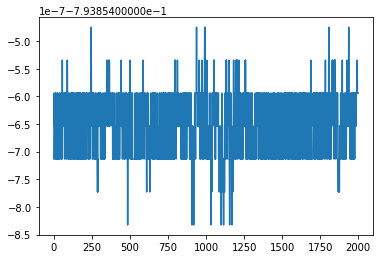

Target well : 31/2-1, 2, 
Source well : ('16/2-6', array([1341, 4822, 5874, 7039, 7835, 7940, 8815]), array([1., 2., 3., 4., 5., 6., 7.], dtype=float32)), 
matching target loc: 1327.46167 vs 1442.064453

------------------------------------------------------
------------------------------------------------------

correlation shape : (9925,)


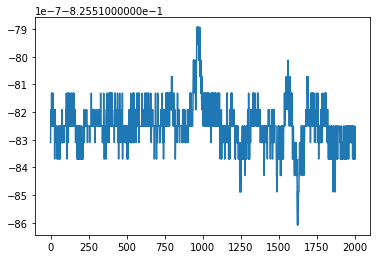

Target well : 31/2-1, 3, 
Source well : ('16/2-16', array([2025, 5400, 6584, 7499, 8301, 8420, 8650, 9084, 9742]), array([1., 2., 3., 4., 5., 6., 8., 7., 9.], dtype=float32)), 
matching target loc: 1658.673584 vs 1658.673584

------------------------------------------------------
------------------------------------------------------

correlation shape : (9038,)


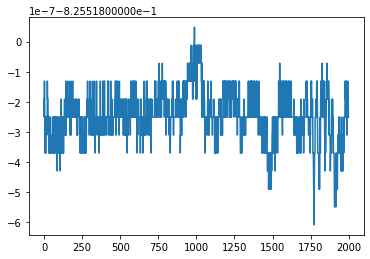

Target well : 31/2-1, 3, 
Source well : ('16/2-6', array([1341, 4822, 5874, 7039, 7835, 7940, 8815]), array([1., 2., 3., 4., 5., 6., 7.], dtype=float32)), 
matching target loc: 1602.572388 vs 1601.964355

------------------------------------------------------
------------------------------------------------------

correlation shape : (9925,)


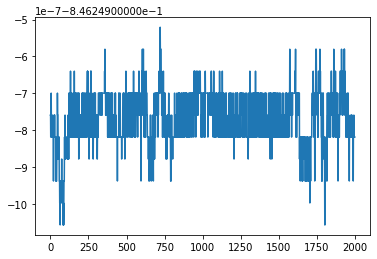

Target well : 31/2-1, 4, 
Source well : ('16/2-16', array([2025, 5400, 6584, 7499, 8301, 8420, 8650, 9084, 9742]), array([1., 2., 3., 4., 5., 6., 8., 7., 9.], dtype=float32)), 
matching target loc: 1795.321533 vs 1797.75354

------------------------------------------------------
------------------------------------------------------

correlation shape : (9038,)


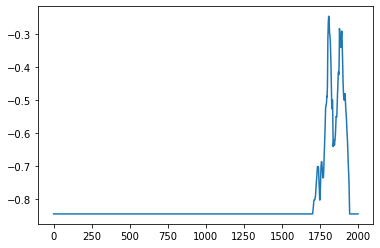

Target well : 31/2-1, 4, 
Source well : ('16/2-6', array([1341, 4822, 5874, 7039, 7835, 7940, 8815]), array([1., 2., 3., 4., 5., 6., 7.], dtype=float32)), 
matching target loc: 1776.457886 vs 1779.041748

------------------------------------------------------
------------------------------------------------------

correlation shape : (9925,)


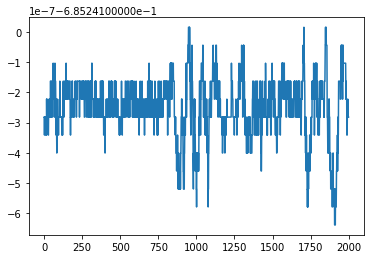

Target well : 31/2-1, 5, 
Source well : ('16/2-16', array([2025, 5400, 6584, 7499, 8301, 8420, 8650, 9084, 9742]), array([1., 2., 3., 4., 5., 6., 8., 7., 9.], dtype=float32)), 
matching target loc: 1915.24939 vs 1919.657227

------------------------------------------------------
------------------------------------------------------

correlation shape : (9038,)


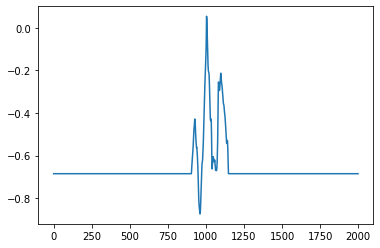

Target well : 31/2-1, 5, 
Source well : ('16/2-6', array([1341, 4822, 5874, 7039, 7835, 7940, 8815]), array([1., 2., 3., 4., 5., 6., 7.], dtype=float32)), 
matching target loc: 1900.025635 vs 1900.025635

------------------------------------------------------
------------------------------------------------------

correlation shape : (9925,)


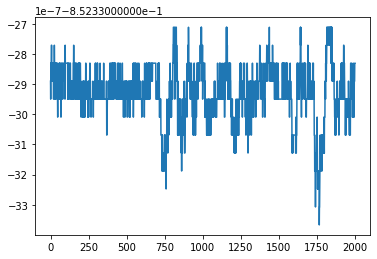

Target well : 31/2-1, 6, 
Source well : ('16/2-16', array([2025, 5400, 6584, 7499, 8301, 8420, 8650, 9084, 9742]), array([1., 2., 3., 4., 5., 6., 8., 7., 9.], dtype=float32)), 
matching target loc: 1937.441284 vs 1937.745239

------------------------------------------------------
------------------------------------------------------

correlation shape : (9038,)


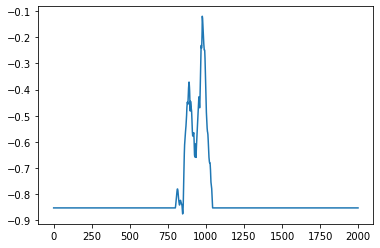

Target well : 31/2-1, 6, 
Source well : ('16/2-6', array([1341, 4822, 5874, 7039, 7835, 7940, 8815]), array([1., 2., 3., 4., 5., 6., 7.], dtype=float32)), 
matching target loc: 1915.984619 vs 1915.984619

------------------------------------------------------
------------------------------------------------------

correlation shape : (9925,)


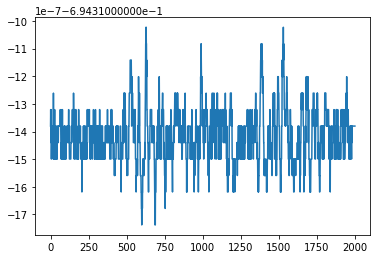

Target well : 31/2-1, 8, 
Source well : ('16/2-16', array([2025, 5400, 6584, 7499, 8301, 8420, 8650, 9084, 9742]), array([1., 2., 3., 4., 5., 6., 8., 7., 9.], dtype=float32)), 
matching target loc: 1972.097046 vs 1972.705078

------------------------------------------------------
------------------------------------------------------

correlation shape : (9038,)
Target well : 31/2-1, 8, 
Source well : ('16/2-6', array([1341, 4822, 5874, 7039, 7835, 7940, 8815]), array([1., 2., 3., 4., 5., 6., 7.], dtype=float32)), 
matching target loc: Not applicable vs Not found

------------------------------------------------------
------------------------------------------------------



In [81]:
matching_wells = dataset.get_matching_wells_id("16/2")
print(f'matching wells ids : {matching_wells}')
get_matching_results(matching_wells)

In [58]:
df_w1_reference = dataset.get_well(matching_wells[0])

In [65]:
idx, templates = get_window(df_w1_reference, w_size=100, asymmetric=False)

In [66]:
print(idx, df_w1_reference.iloc[idx].GROUP_NUM.values, df_w1_reference.iloc[idx].GROUP.values)

[ 126 1580 1640 4712 5396 8001] [ 2  4  5 13 12  8] ['ROGALAND GP.' 'CROMER KNOLL GP.' 'VIKING GP.' 'BAAT GP.' 'DUNLIN GP.'
 'HEGRE GP.']


correlation shape : (16355,)


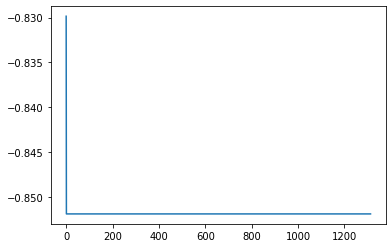

Target well : 31/2-1, 2, 
Source well : ('31/2-19 S', array([  314,  3874,  6314,  6841, 12453, 13532]), array([ 2.,  3.,  4.,  5., 13., 12.], dtype=float32)), 
matching target loc: 1559.671753 vs 1560.697998

------------------------------------------------------
------------------------------------------------------

correlation shape : (7904,)


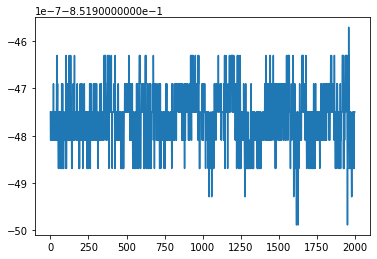

Target well : 31/2-1, 2, 
Source well : ('31/2-7', array([2213, 5687, 7180, 7207]), array([1., 2., 4., 5.], dtype=float32)), 
matching target loc: 1610.057983 vs 1279.025757

------------------------------------------------------
------------------------------------------------------

correlation shape : (18925,)


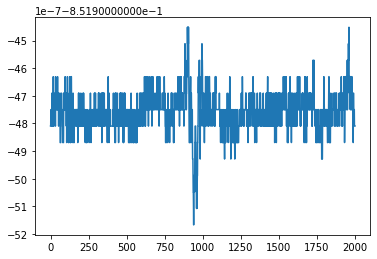

Target well : 31/2-1, 2, 
Source well : ('31/2-8', array([ 1918,  6233,  8733,  8819, 13391, 14713, 18328]), array([ 1.,  2.,  3.,  5., 13., 12.,  8.], dtype=float32)), 
matching target loc: 1402.498535 vs 1402.95459

------------------------------------------------------
------------------------------------------------------

correlation shape : (8599,)


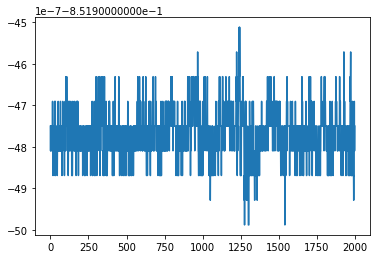

Target well : 31/2-1, 2, 
Source well : ('31/2-9', array([2127, 5581, 7213, 7239]), array([1., 2., 4., 5.], dtype=float32)), 
matching target loc: 1261.958862 vs 1266.974243

------------------------------------------------------
------------------------------------------------------

correlation shape : (16355,)


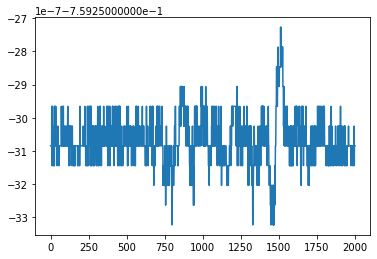

Target well : 31/2-1, 4, 
Source well : ('31/2-19 S', array([  314,  3874,  6314,  6841, 12453, 13532]), array([ 2.,  3.,  4.,  5., 13., 12.], dtype=float32)), 
matching target loc: 2297.78833 vs 2298.14502

------------------------------------------------------
------------------------------------------------------

correlation shape : (7904,)


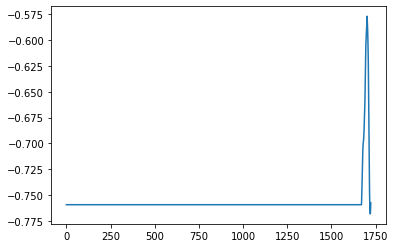

Target well : 31/2-1, 4, 
Source well : ('31/2-7', array([2213, 5687, 7180, 7207]), array([1., 2., 4., 5.], dtype=float32)), 
matching target loc: 1611.729858 vs 1505.940918

------------------------------------------------------
------------------------------------------------------

correlation shape : (18925,)
Target well : 31/2-1, 4, 
Source well : ('31/2-8', array([ 1918,  6233,  8733,  8819, 13391, 14713, 18328]), array([ 1.,  2.,  3.,  5., 13., 12.,  8.], dtype=float32)), 
matching target loc: Not applicable vs Not found

------------------------------------------------------
------------------------------------------------------

correlation shape : (8599,)


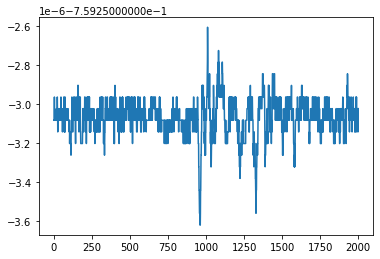

Target well : 31/2-1, 4, 
Source well : ('31/2-9', array([2127, 5581, 7213, 7239]), array([1., 2., 4., 5.], dtype=float32)), 
matching target loc: 1516.017334 vs 1514.953857

------------------------------------------------------
------------------------------------------------------

correlation shape : (16355,)


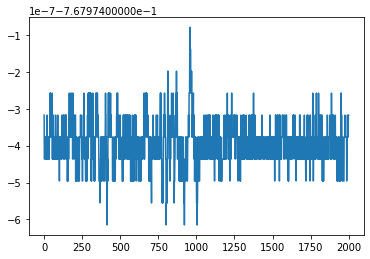

Target well : 31/2-1, 5, 
Source well : ('31/2-19 S', array([  314,  3874,  6314,  6841, 12453, 13532]), array([ 2.,  3.,  4.,  5., 13., 12.], dtype=float32)), 
matching target loc: 2358.592529 vs 2360.988281

------------------------------------------------------
------------------------------------------------------

correlation shape : (7904,)


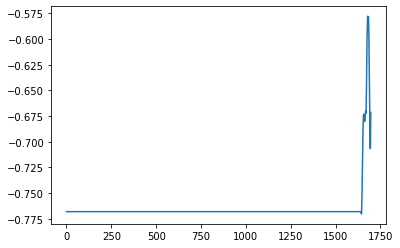

Target well : 31/2-1, 5, 
Source well : ('31/2-7', array([2213, 5687, 7180, 7207]), array([1., 2., 4., 5.], dtype=float32)), 
matching target loc: 1611.425781 vs 1510.0448

------------------------------------------------------
------------------------------------------------------

correlation shape : (18925,)


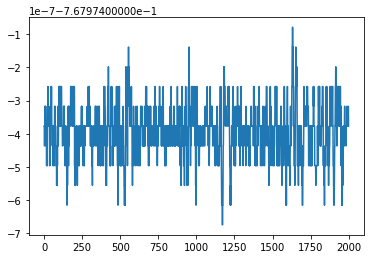

Target well : 31/2-1, 5, 
Source well : ('31/2-8', array([ 1918,  6233,  8733,  8819, 13391, 14713, 18328]), array([ 1.,  2.,  3.,  5., 13., 12.,  8.], dtype=float32)), 
matching target loc: 1796.593994 vs 1795.986206

------------------------------------------------------
------------------------------------------------------

correlation shape : (8599,)


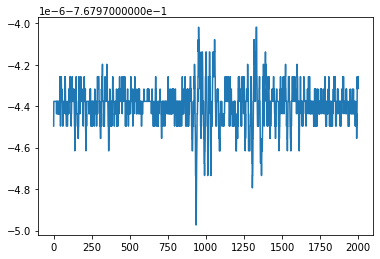

Target well : 31/2-1, 5, 
Source well : ('31/2-9', array([2127, 5581, 7213, 7239]), array([1., 2., 4., 5.], dtype=float32)), 
matching target loc: 1518.903564 vs 1518.903564

------------------------------------------------------
------------------------------------------------------

correlation shape : (16355,)


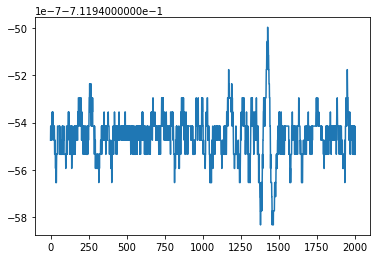

Target well : 31/2-1, 13, 
Source well : ('31/2-19 S', array([  314,  3874,  6314,  6841, 12453, 13532]), array([ 2.,  3.,  4.,  5., 13., 12.], dtype=float32)), 
matching target loc: 3070.519775 vs 3070.638916

------------------------------------------------------
------------------------------------------------------

correlation shape : (7904,)
Target well : 31/2-1, 13, 
Source well : ('31/2-7', array([2213, 5687, 7180, 7207]), array([1., 2., 4., 5.], dtype=float32)), 
matching target loc: Not applicable vs Not found

------------------------------------------------------
------------------------------------------------------

correlation shape : (18925,)


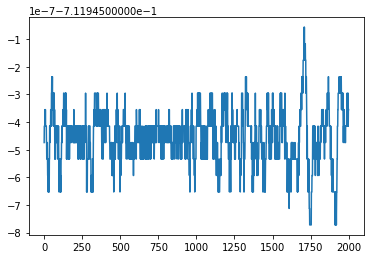

Target well : 31/2-1, 13, 
Source well : ('31/2-8', array([ 1918,  6233,  8733,  8819, 13391, 14713, 18328]), array([ 1.,  2.,  3.,  5., 13., 12.,  8.], dtype=float32)), 
matching target loc: 2537.123291 vs 2491.877441

------------------------------------------------------
------------------------------------------------------

correlation shape : (8599,)
Target well : 31/2-1, 13, 
Source well : ('31/2-9', array([2127, 5581, 7213, 7239]), array([1., 2., 4., 5.], dtype=float32)), 
matching target loc: Not applicable vs Not found

------------------------------------------------------
------------------------------------------------------

correlation shape : (16355,)


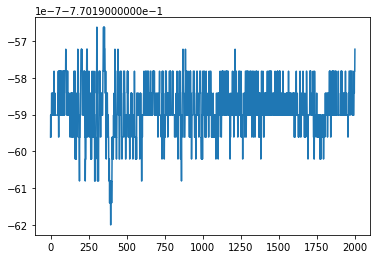

Target well : 31/2-1, 12, 
Source well : ('31/2-19 S', array([  314,  3874,  6314,  6841, 12453, 13532]), array([ 2.,  3.,  4.,  5., 13., 12.], dtype=float32)), 
matching target loc: 3201.791504 vs 3201.791504

------------------------------------------------------
------------------------------------------------------

correlation shape : (7904,)
Target well : 31/2-1, 12, 
Source well : ('31/2-7', array([2213, 5687, 7180, 7207]), array([1., 2., 4., 5.], dtype=float32)), 
matching target loc: Not applicable vs Not found

------------------------------------------------------
------------------------------------------------------

correlation shape : (18925,)


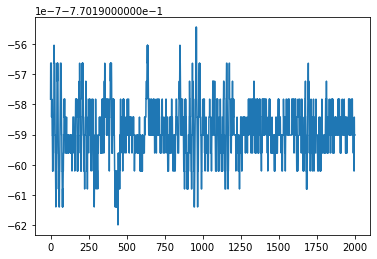

Target well : 31/2-1, 12, 
Source well : ('31/2-8', array([ 1918,  6233,  8733,  8819, 13391, 14713, 18328]), array([ 1.,  2.,  3.,  5., 13., 12.,  8.], dtype=float32)), 
matching target loc: 2691.661377 vs 2695.15332

------------------------------------------------------
------------------------------------------------------

correlation shape : (8599,)
Target well : 31/2-1, 12, 
Source well : ('31/2-9', array([2127, 5581, 7213, 7239]), array([1., 2., 4., 5.], dtype=float32)), 
matching target loc: Not applicable vs Not found

------------------------------------------------------
------------------------------------------------------

correlation shape : (16355,)
Target well : 31/2-1, 8, 
Source well : ('31/2-19 S', array([  314,  3874,  6314,  6841, 12453, 13532]), array([ 2.,  3.,  4.,  5., 13., 12.], dtype=float32)), 
matching target loc: Not applicable vs Not found

------------------------------------------------------
------------------------------------------------------

cor

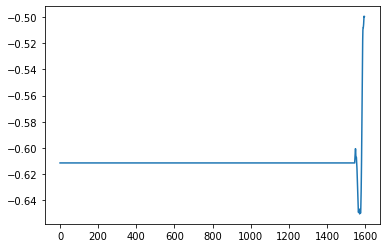

Target well : 31/2-1, 8, 
Source well : ('31/2-8', array([ 1918,  6233,  8733,  8819, 13391, 14713, 18328]), array([ 1.,  2.,  3.,  5., 13., 12.,  8.], dtype=float32)), 
matching target loc: 3247.153564 vs 3247.153564

------------------------------------------------------
------------------------------------------------------

correlation shape : (8599,)
Target well : 31/2-1, 8, 
Source well : ('31/2-9', array([2127, 5581, 7213, 7239]), array([1., 2., 4., 5.], dtype=float32)), 
matching target loc: Not applicable vs Not found

------------------------------------------------------
------------------------------------------------------



In [70]:
for idx_, group_num, template in zip(idx, df_w1_reference.iloc[idx].GROUP_NUM.values, templates):
    # Define target template
    target_template = np.float32(template).T
    target_template /= np.linalg.norm(target_template, axis=1, keepdims=True)+0.000001
    target_template /= np.linalg.norm(target_template, axis=0, keepdims=True)+0.000001
    target_template = torch.from_numpy(target_template).unsqueeze(dim=0)
    target_template = target_template.to(device)
    
    for well in matching_wells[1:]:
        source_df = dataset.get_well(well)
        
        correlation_vals = match(source_df, target_template)
        
        print(f'correlation shape : {correlation_vals.shape}')
        matching_idx = np.argsort(correlation_vals)[-len(correlation_vals)//20:]
        matching_z_vals = source_df.Z_LOC.values[matching_idx]
        correlation_vals_match = correlation_vals[matching_idx]
        
        source_idx, _ = get_window(source_df, w_size=100, asymmetric=False)
        group_nums = np.float32(source_df.iloc[source_idx].GROUP_NUM.values)
        gt_id = source_idx[group_nums == group_num]
        gt_matching_loc = source_df.Z_LOC.values[gt_id]
        
        matching_z_val = 'Not applicable'
        
        if len(gt_matching_loc) == 0:
            gt_matching_loc = 'Not found'
        else:
            gt_matching_loc = gt_matching_loc[0]
            matching_z_val = matching_z_vals[np.argmin(np.abs(matching_z_vals - gt_matching_loc))]
            plt.plot(correlation_vals[max(gt_id[0]-1000, 0):min(gt_id[0]+1000, len(correlation_vals))])
            plt.show()
        
        print(f'Target well : 31/2-1, {group_num}, \nSource well : {well, source_idx, group_nums}, \nmatching target loc: {matching_z_val} vs {gt_matching_loc}')
        print('\n------------------------------------------------------')
        print('------------------------------------------------------\n')